In [1]:
# Loading in libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import seaborn as sns

In [13]:
# Loading in Data
avg_play = pd.read_csv("Cleaned_Data/Full_Data_With_Plays.csv").rename(columns={'track_name_x':'track_name',
                                                                        'artist_name_x':'artist_name',
                                                                        'artist_id_x':'artist_id',
                                                                        'genres_x':'genres',
                                                                        'track_popularity_x':'track_popularity'}).drop(columns=['track_name_y', 'artist_name_y', 
                                                                                                                               'artist_id_y', 'genres_y', 'track_popularity_y'])
features = avg_play[['artist_id', 'track_name', 'genres', 'track_popularity', 'artist_name', 'track_id', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature']]

# Exploratory Data Analysis

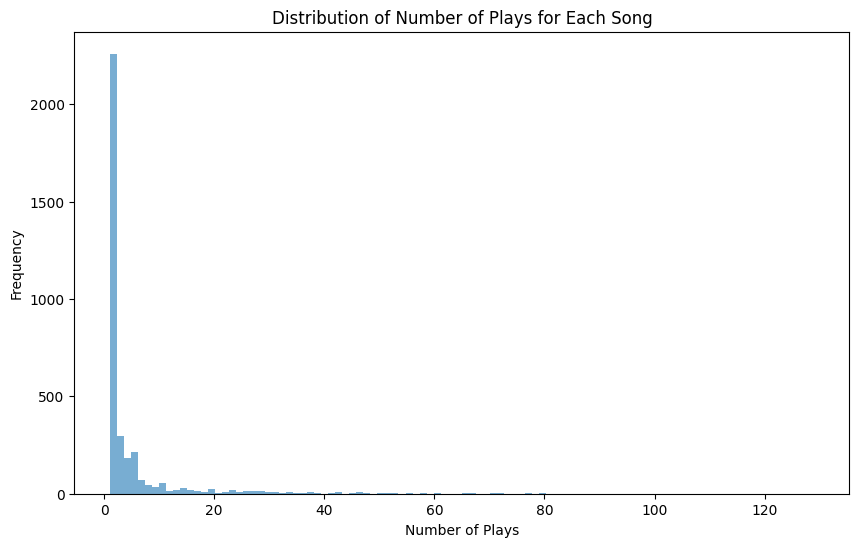

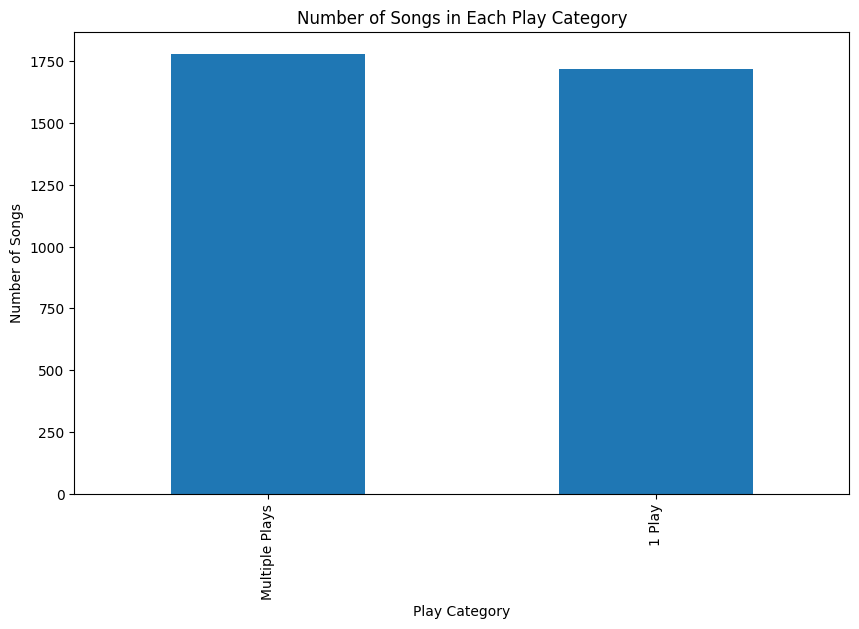

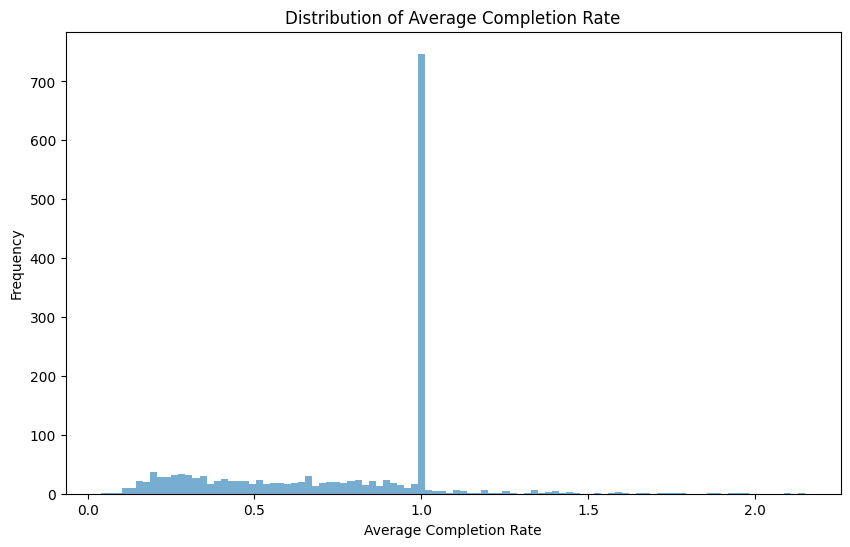

In [14]:
# Distribution of number of plays for each song
plt.figure(figsize=(10, 6))
plt.hist(avg_play['total_plays'], bins=100, alpha=0.6, label='Number of Plays')
plt.xlabel('Number of Plays')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Plays for Each Song')


# Chart of songs with 1 play or multiple plays
avg_play['play_category'] = '1 Play'
avg_play.loc[avg_play['total_plays'] >= 2, 'play_category'] = 'Multiple Plays'
plt.figure(figsize=(10, 6))
avg_play['play_category'].value_counts().plot(kind='bar')
plt.xlabel('Play Category')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Play Category')

# Distribution of avg_completion_rate
plt.figure(figsize=(10, 6))
plt.hist(avg_play[avg_play['play_category'] == '1 Play']['avg_completion_rate'], bins=100, alpha=0.6, label='Average Completion Rate')
plt.xlabel('Average Completion Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Average Completion Rate')
plt.show()

Based on these graphs, my preliminary criteria for songs that I enjoyed would be songs that I either played multiple times or songs with an average completion rate of at least 1.25. This way, I can capture songs that I may have forgotten about, but enjoyed during my initial listen as well as songs that I came back to.

In [15]:
# Make a column called 'enjoyed' in avg_play that is True if the avg_completion_rate is greater than 1.25 or the total_plays is greater than 1
avg_play['enjoyed'] = (avg_play['avg_completion_rate'] >= 1.25) | (avg_play['total_plays'] > 1)

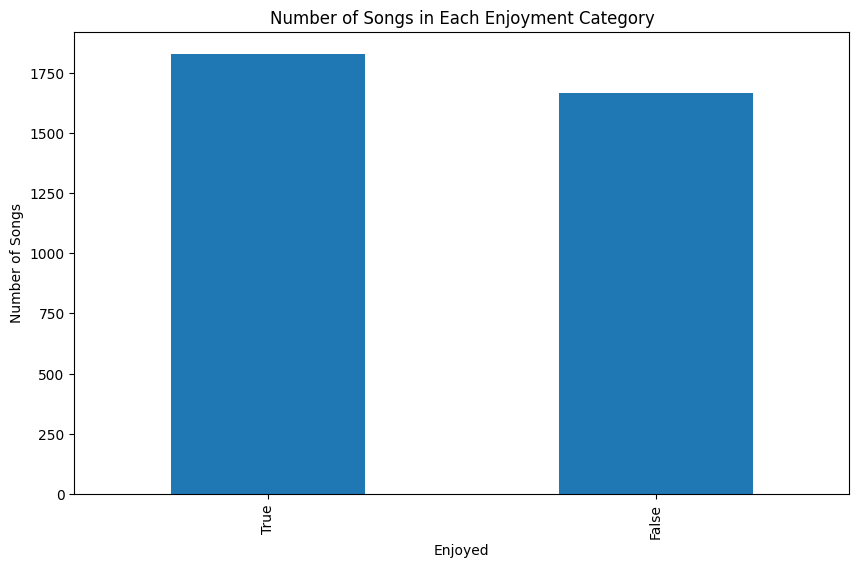

In [16]:
# plot the distribution of the 'enjoyed' column
plt.figure(figsize=(10, 6))
avg_play['enjoyed'].value_counts().plot(kind='bar')
plt.xlabel('Enjoyed')
plt.ylabel('Number of Songs')
plt.title('Number of Songs in Each Enjoyment Category')
plt.show()

This criteria returns about an even split between songs I enjoyed and songs that I did not, which is important for the classification I will perform later.

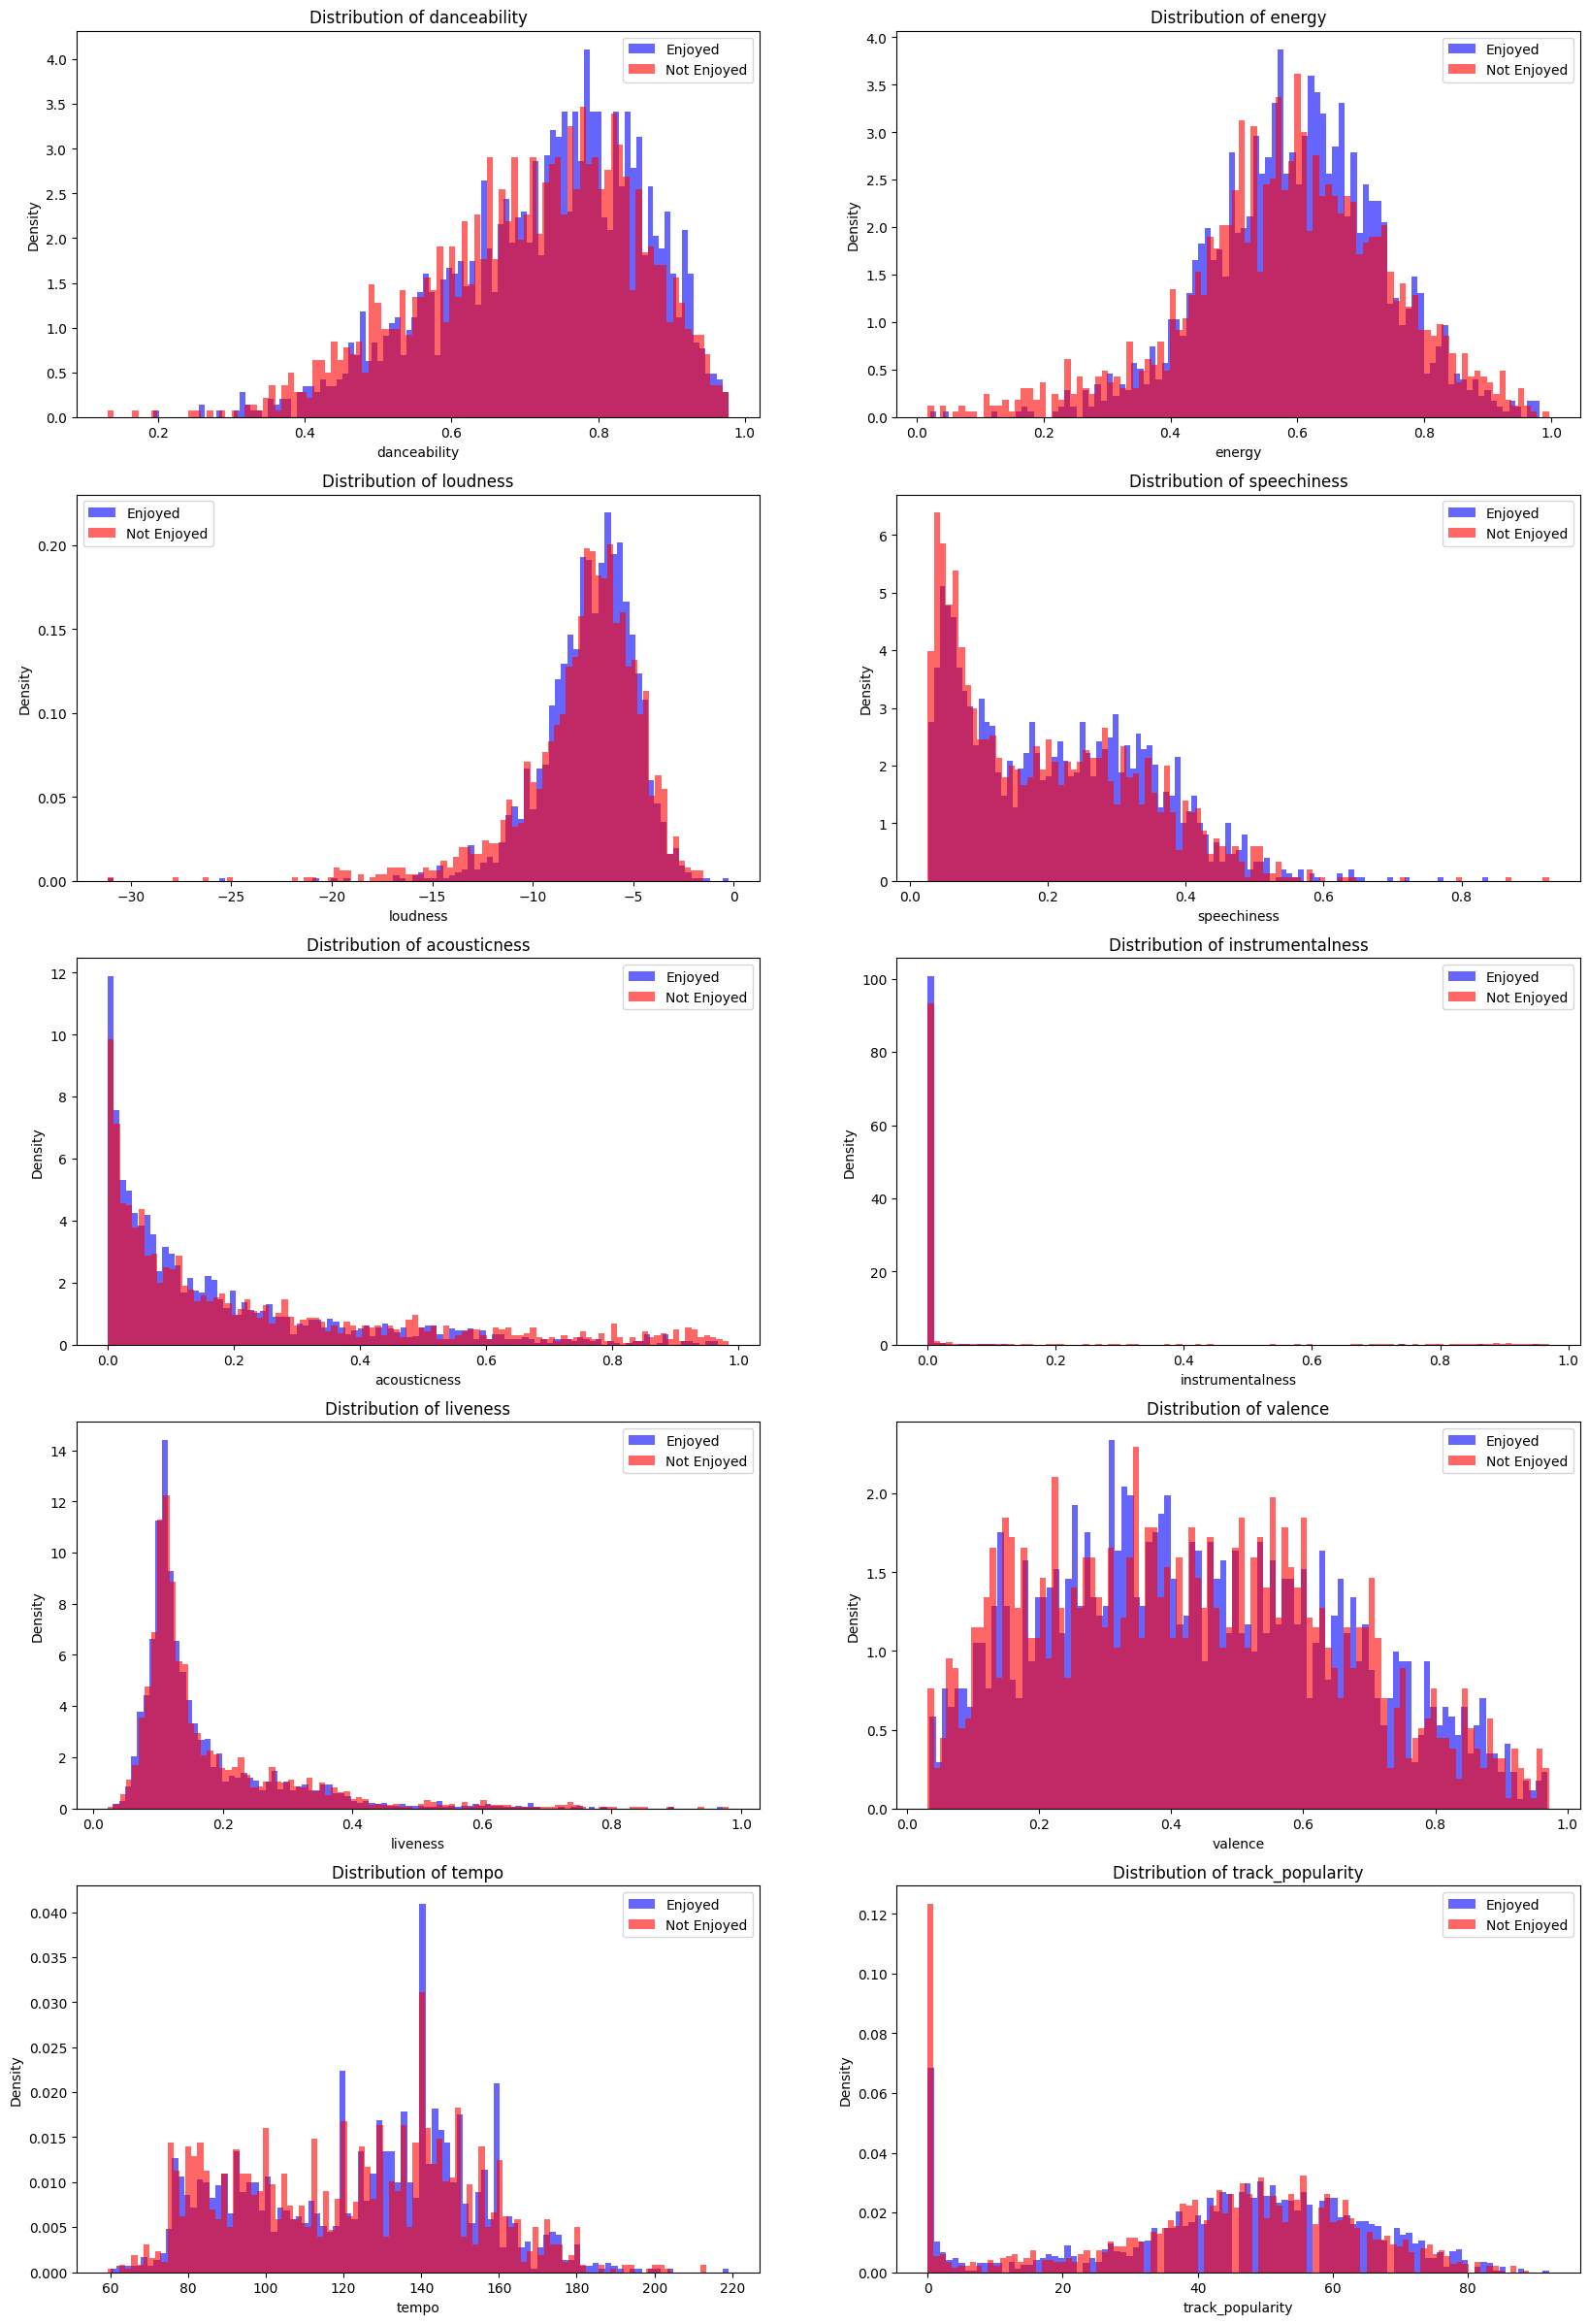

In [17]:
avg_play2 = avg_play.copy()
audio_features = ['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'track_popularity']

# One-hot encode the 'time_signature' column and the 'key' column
avg_play2 = pd.get_dummies(avg_play2, columns=['time_signature', 'key'])


# Plot the distribution of each audio feature in a grid of subplots
plt.figure(figsize=(20, 30))
for i, feature in enumerate(audio_features):
    plt.subplot(5, 2, i + 1)
    plt.hist(avg_play2[avg_play2['enjoyed'] == True][feature], bins=100, alpha=0.6, label='Enjoyed', color='blue', density=True)
    plt.hist(avg_play2[avg_play2['enjoyed'] == False][feature], bins=100, alpha=0.6, label='Not Enjoyed', color='red', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('Distribution of ' + feature)
    plt.legend()


Some of these variables have obvious skews. Loudness, acousticness, speechiness, instrumentalness, and liveness all would benefit from a log-transform or standardization to reduce the skew and compress outliers. Also, instrumentalness does not seem to be an informative predictor, so I will get rid of it here. Below are the update distributions:

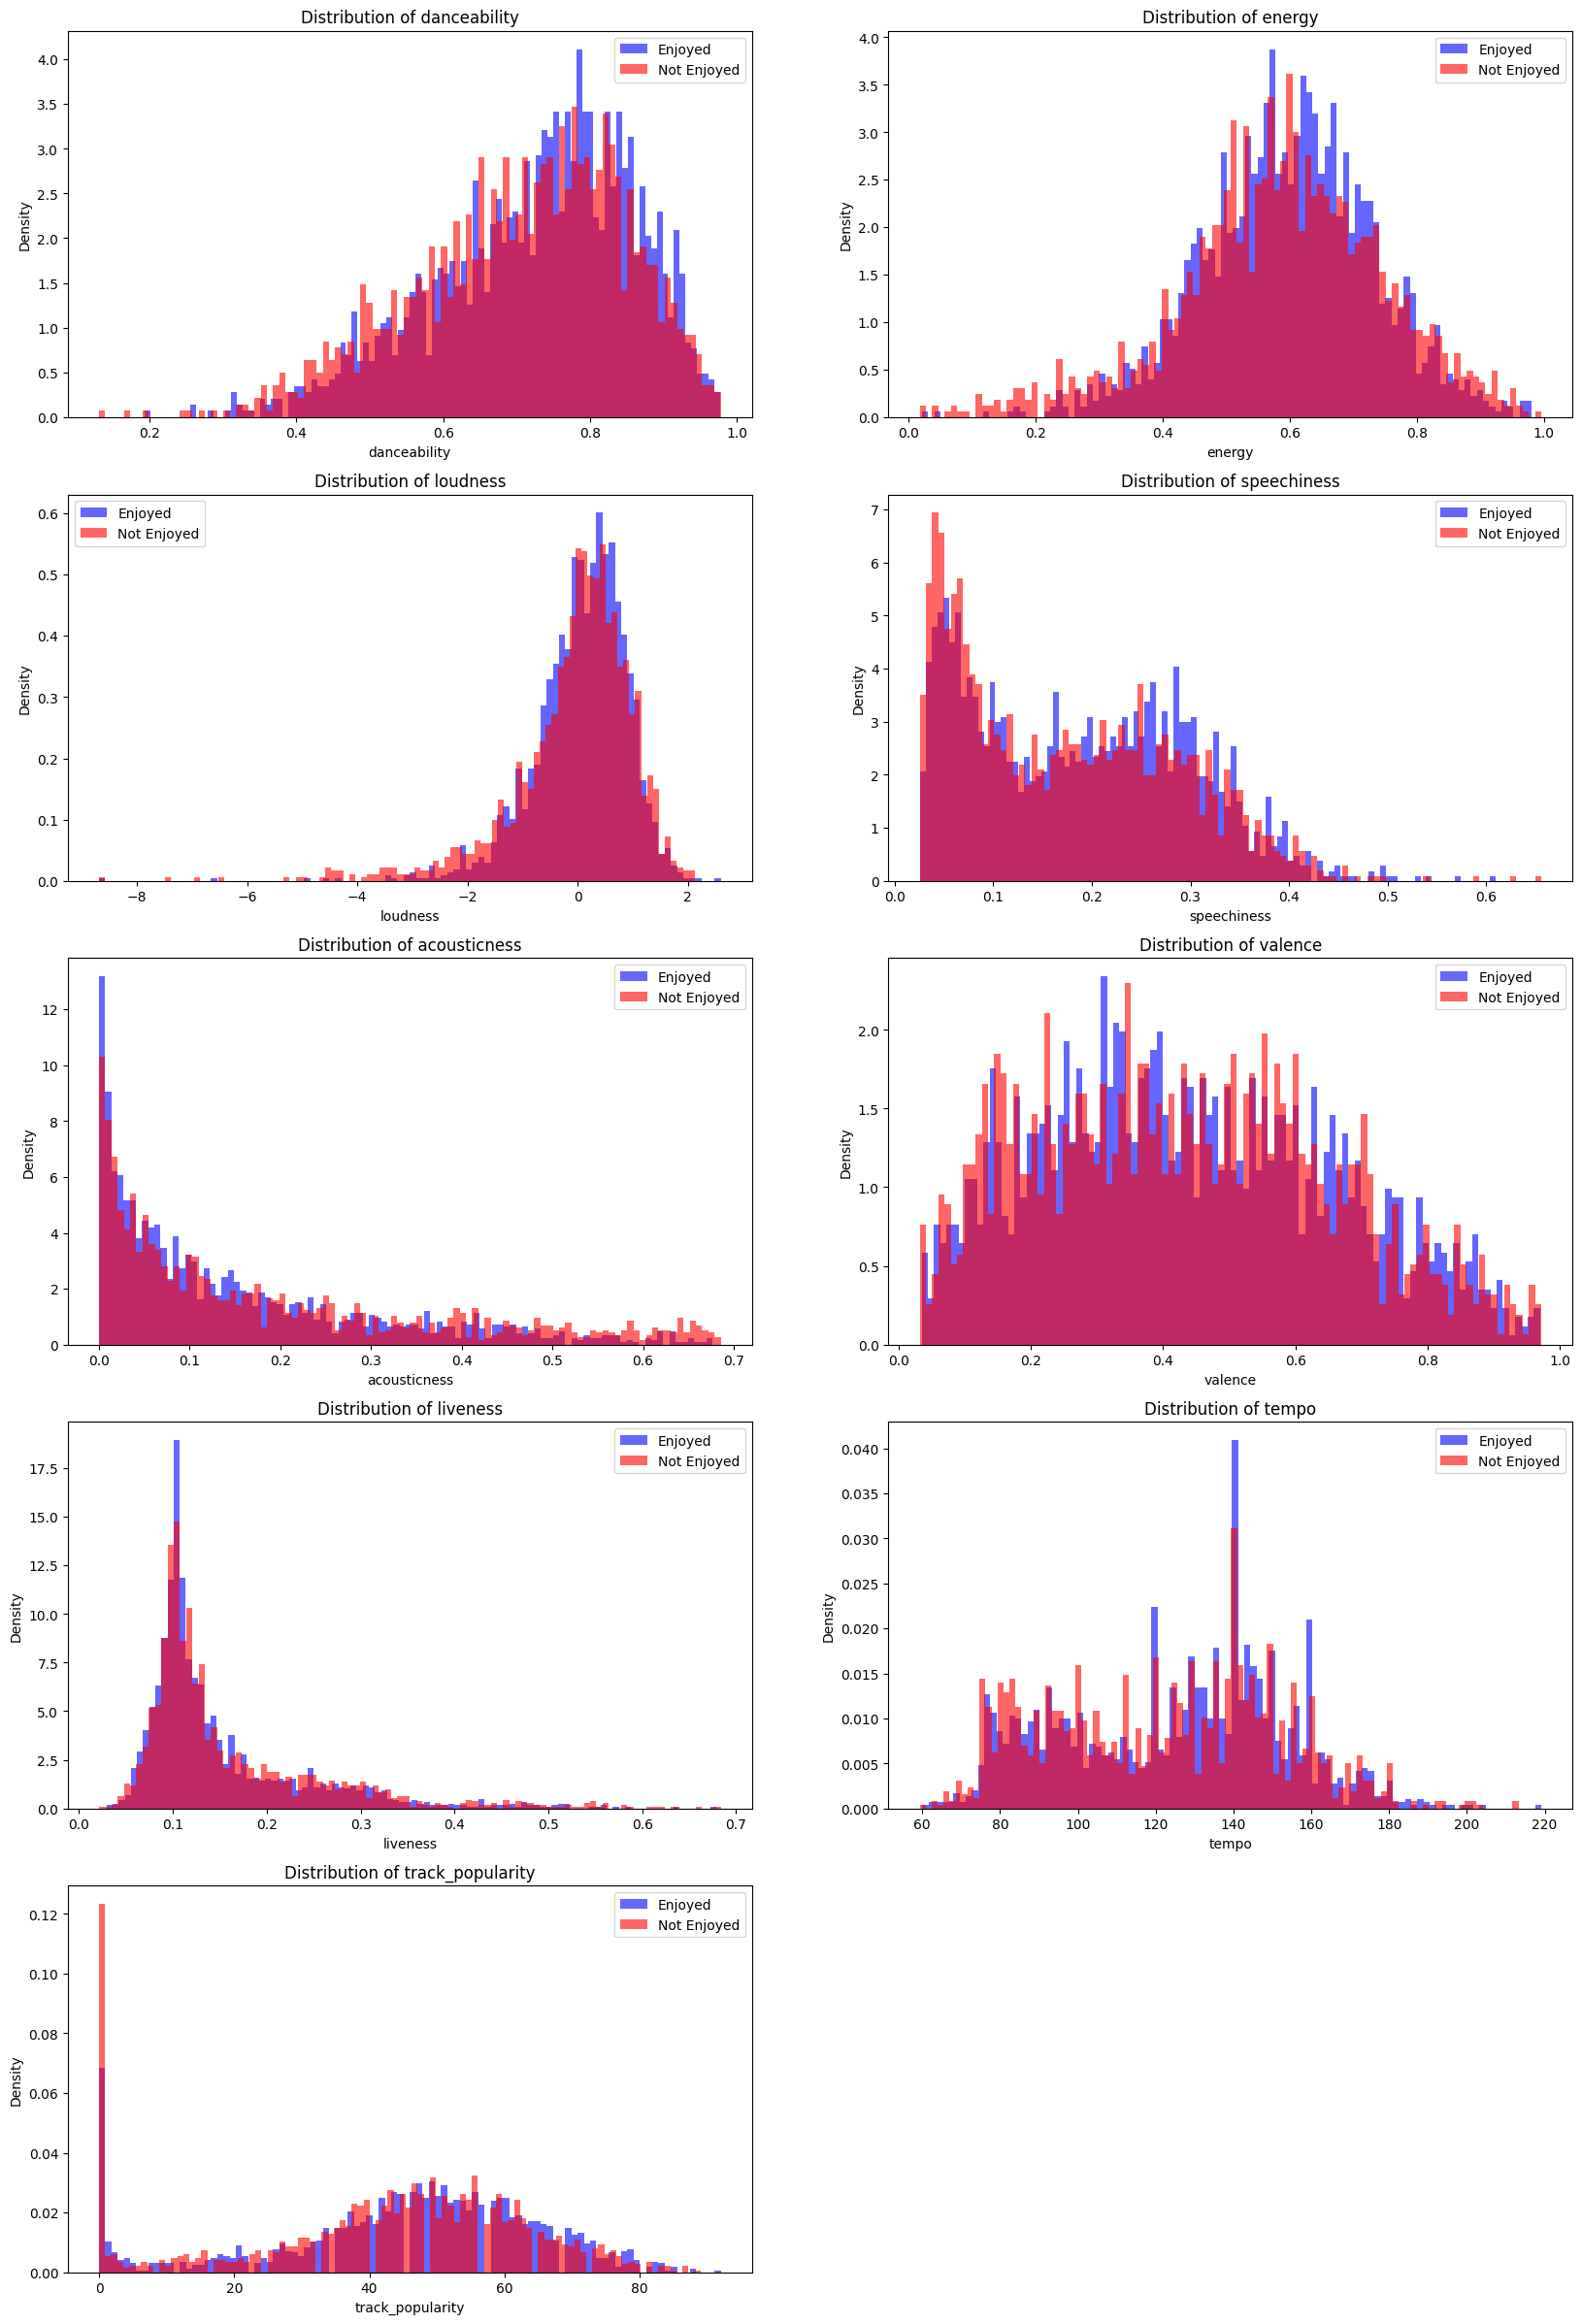

In [19]:
audio_features = ['danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'valence',
       'liveness', 'tempo', 'track_popularity']


# Standardize loudness
avg_play2['loudness'] = (avg_play2['loudness'] - avg_play2['loudness'].mean()) / avg_play2['loudness'].std()

# apply log(1 +x) transformation to loudness, acousticness, speechiness, and liveness
avg_play2['acousticness'] = np.log1p(avg_play2['acousticness'])
avg_play2['speechiness'] = np.log1p(avg_play2['speechiness'])
avg_play2['liveness'] = np.log1p(avg_play2['liveness'])

plt.figure(figsize=(20, 30))
for i, feature in enumerate(audio_features):
    plt.subplot(5, 2, i + 1)
    plt.hist(avg_play2[avg_play2['enjoyed'] == True][feature], bins=100, alpha=0.6, label='Enjoyed', color='blue', density=True)
    plt.hist(avg_play2[avg_play2['enjoyed'] == False][feature], bins=100, alpha=0.6, label='Not Enjoyed', color='red', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title('Distribution of ' + feature)
    plt.legend()

Before modeling, I want to check for multicollinearity, as it is an assumption made by both LASSO regression and Logistic Classification.

In [21]:
# Select the numeric features
X_features = avg_play2[audio_features + [col for col in avg_play2.columns if 'time_signature' in col or 'key' in col]]
# Drop one column from 'time_signature' and 'key' as the reference category
X_features_fixed = X_features.drop(columns=['time_signature_5.0', 'key_0.0'])

# Calculate VIF
scaler = StandardScaler()
X_scaled_fixed = scaler.fit_transform(X_features_fixed)

vif_fixed = pd.DataFrame()
vif_fixed["Feature"] = X_features_fixed.columns
vif_fixed["VIF"] = [variance_inflation_factor(X_scaled_fixed, i) for i in range(X_scaled_fixed.shape[1])]

vif_fixed.sort_values(by="VIF", ascending=False)

,Feature,VIF
12,key_1.0,3.088966
1,energy,2.684232
11,time_signature_4.0,2.554757
2,loudness,2.431251
10,time_signature_3.0,2.310737
16,key_5.0,2.064412
13,key_2.0,1.978676
21,key_10.0,1.959357
22,key_11.0,1.933872
19,key_8.0,1.889869


All features have VIF values of below 5, indicating no severe multicollinearity. I will now proceed with my modeling.

# Modeling & Analysis

In [26]:
# Define target and feature set
X = X_features_fixed  # Features after removing multicollinearity
y = avg_play2['enjoyed'].astype(int)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train LASSO Regression with Cross-Validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

# Display non-zero coefficients (important features)
feature_importance = pd.DataFrame({"LASSO Feature Coefficients":pd.Series(lasso.coef_, index=X.columns)})
display(feature_importance[feature_importance != 0].dropna().sort_values(by='LASSO Feature Coefficients', ascending=False))

# Predict on test data
y_pred = lasso.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-Squared: {r2:.4f}")

,LASSO Feature Coefficients
track_popularity,0.036461
speechiness,0.021502
danceability,0.011868
tempo,0.007267
key_4.0,0.006978
time_signature_3.0,0.006128
loudness,0.001941
key_1.0,0.000699
key_6.0,-0.001781
time_signature_4.0,-0.004950


Mean Squared Error: 0.2436
R-Squared: 0.0207


The model indicates that higher values of features like track_popularity, speechiness, and danceability increase the likelihood of a song being "enjoyed," while features such as acousticness, liveness, and time_signature_4.0 have a negative impact. Among these, track_popularity emerges as the strongest predictor, suggesting that more popular tracks are more likely to be enjoyed. Additionally, songs with moderate speech content and higher danceability are favored, whereas high acousticness reduces enjoyment. The model's performance, with an R-squared of 2% and a mean squared error of 0.24, reflects modest predictive power, which is expected given the complexity of behavioral preferences like song enjoyment. However, a classification model may prove to be more effective at prediction.

# Binary Classification (Logistic Regression)


Accuracy: 0.5571


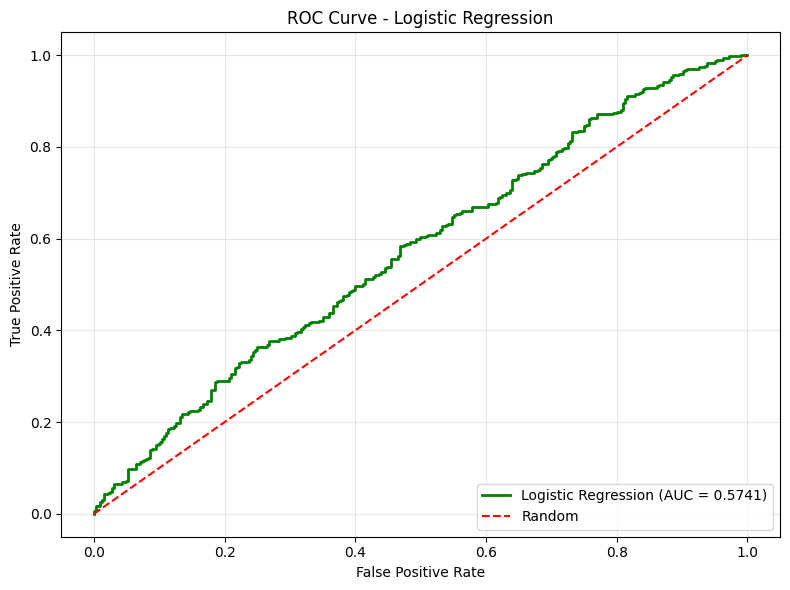

In [29]:
# Initialize Logistic Regression with better parameters
logreg_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 20),      # Range of inverse regularization strengths
    cv=5,                           # 5-fold cross-validation
    scoring='roc_auc',              # Optimize for ROC AUC
    max_iter=2000,                  # Increase max iterations
    penalty='l2',                   # L2 regularization
    solver='lbfgs',                 # Efficient solver for L2
    n_jobs=-1,                      # Use all processors
    random_state=42)

# Fit the model
logreg_cv.fit(X_train_scaled, y_train)

# Get predictions
y_pred = logreg_cv.predict(X_test_scaled)
y_pred_prob = logreg_cv.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc_lr = roc_auc_score(y_test, y_pred_prob)

# Calculate ROC curve
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve with improved styling
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

print(f"\nAccuracy: {accuracy:.4f}")

The ROC curve shows an AUC of 0.574, indicating that the logistic regression model performs only slightly better than random guessing (AUC = 0.5). The curve’s proximity to the diagonal line reflects the model's limited ability to distinguish between "enjoyed" and "not enjoyed" songs. This suggests that the current features may not sufficiently capture the patterns in song enjoyment, and the linear nature of logistic regression may not be well-suited for the complexity of the data. I will now try models that do not assume linear relationships between the larget variable and the features.

Fitting 5 folds for each of 50 candidates, totalling 250 fits


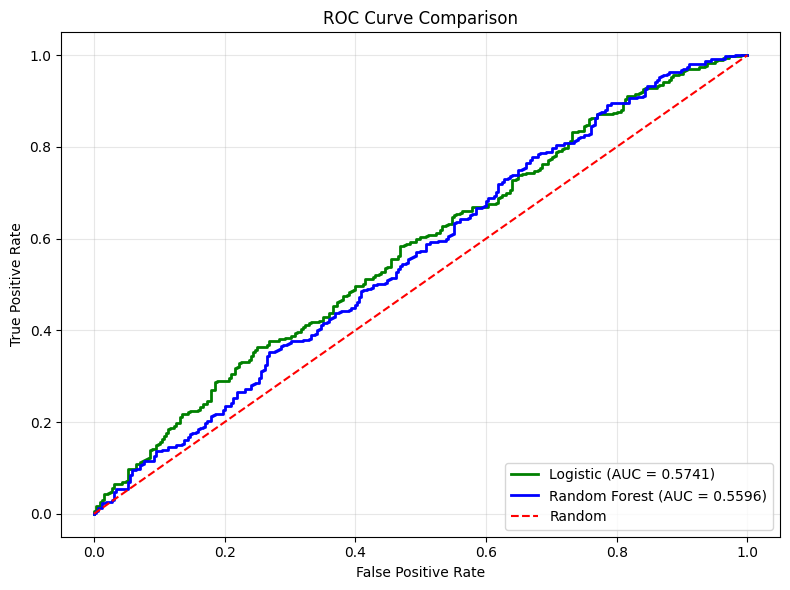


Random Forest Metrics:
Accuracy: 0.5614
ROC AUC: 0.5596


In [30]:
# Define the hyperparameter grid for cross-validation
param_distributions = {
    'n_estimators': [100, 200, 300],        # Fewer trees
    'max_depth': [3, 4, 5, 6],              # Much shallower trees
    'min_samples_split': [10, 20, 30],      # Require more samples to split
    'min_samples_leaf': [10, 20, 30],       # Much larger leaf size
    'max_features': ['sqrt']                # Simpler feature selection
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    bootstrap=True
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='roc_auc',           # Just use one metric
    verbose=1,
    random_state=42,
    n_jobs=-1
)
# Fit and get predictions
random_search.fit(X_train_scaled, y_train)
best_rf = random_search.best_estimator_

# Get predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate all metrics at once
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc_rf = roc_auc_score(y_test, y_pred_prob)

# Calculate ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob)  # We don't need thresholds

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic (AUC = {auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)  # Softer grid
plt.tight_layout()
plt.show()

# Print metrics
print(f"\nRandom Forest Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {auc_rf:.4f}")

While Random Forest typically outperforms Logistic Regression due to its ability to capture complex patterns, in this case of predicting music enjoyment, the simpler Logistic Regression model performed better. This can be attributed to the likely linear relationships between musical features (like danceability, energy, tempo) and enjoyment, along with our relatively small feature space (23 features) which Logistic Regression can handle effectively without overfitting. However, to thoroughly explore our options for prediction, let's evaluate two other powerful ensemble methods: Gradient Boosting and XGBoost. These boosting algorithms might capture patterns that both Random Forest and Logistic Regression missed by learning from previous predictions.

The ROC curve compares the performance of Logistic Regression and Random Forest in predicting whether a song is "enjoyed." The Logistic Regression model achieves an AUC of 0.5599, while the Random Forest model slightly improves upon this with an AUC of 0.5644. Both values are only marginally above 0.5, which indicates that the models perform only slightly better than random guessing. The curves' proximity to the diagonal line reflects the models' limited ability to distinguish between "enjoyed" and "not enjoyed" songs. While Random Forest shows a minor improvement, the results suggest that the current features may not sufficiently capture the patterns driving song enjoyment, and more complex models, such as gradient boosting or XGBoost, or additional features may be needed to improve performance.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


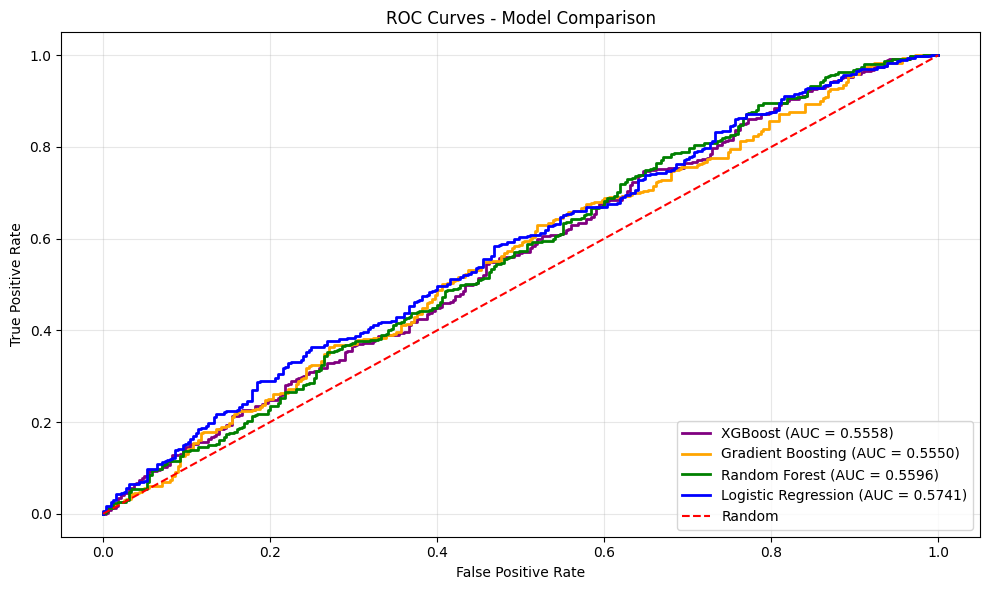

In [31]:
# Define parameter grids for both models
xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

gbc_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize base models
xgb = XGBClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Initialize RandomizedSearchCV for both models
xgb_search = RandomizedSearchCV(
    xgb,
    xgb_params,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

gbc_search = RandomizedSearchCV(
    gbc,
    gbc_params,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit models
xgb_search.fit(X_train_scaled, y_train)
gbc_search.fit(X_train_scaled, y_train)

# Get best models
best_xgb = xgb_search.best_estimator_
best_gbc = gbc_search.best_estimator_

# Get predictions for all models
y_pred_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_prob_gbc = best_gbc.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_prob_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)

# Plot all ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb, tpr_xgb, color='purple', lw=2, 
         label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')
plt.plot(fpr_gbc, tpr_gbc, color='orange', lw=2, 
         label=f'Gradient Boosting (AUC = {roc_auc_gbc:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, 
         label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', 
         label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The comparison of the four models reveals remarkably similar performance, with all models achieving AUC scores between 0.55 and 0.58. Logistic Regression achieved the highest AUC of 0.5749, followed by Random Forest (0.5596), XGBoost (0.5558), and Gradient Boosting (0.5550). While all models performed better than random chance (AUC = 0.5), the marginal improvement suggests that predicting song enjoyment based on audio features and metadata alone is a challenging task. The similar performance across different model complexities, from the simpler Logistic Regression to more complex ensemble methods like XGBoost, indicates that the relationship between the features and music enjoyment might be more straightforward than initially assumed, or that additional features might be needed to achieve better predictive performance. This also suggests that the inherent subjectivity of music preference may limit the predictive power of purely technical audio features.

# Genre Analysis

In [32]:
def consolidate_genre(genre_list_str):
    """
    Convert a string representation of genre list to one of six categories:
    Mainstream Hip Hop, Underground/Alternative Hip Hop, R&B, African/Diasporic, Lo-Fi, or Other
    
    Args:
        genre_list_str (str): String representation of list of genres
        
    Returns:
        str: Single consolidated genre
    """
    if not isinstance(genre_list_str, str) or genre_list_str == '[]':
        return 'Other'
    
    try:
        genres = [g.strip().strip("'") for g in genre_list_str.strip('[]').split(',')]
        genres = [g.strip('"').lower() for g in genres if g.strip()]
    except:
        return 'Other'
    
    # Check for R&B first (highest priority)
    rb_genres = {'r&b', 'soul', 'neo soul', 'contemporary r&b', 'alternative r&b', 
                'neo r&b', 'indie r&b', 'bedroom r&b', 'trap soul', 'experimental r&b', 
                'dark r&b', 'indie soul'}
    if any(rb_genre in genre.lower() for genre in genres for rb_genre in rb_genres):
        return 'R&B'
    
    # Check for African/Diasporic genres
    african_genres = {
        'afrobeats', 'afropop', 'afroswing', 'amapiano', 'azonto', 'bongo flava',
        'azontobeats', 'musique urbaine kinshasa', 'kuduro', 'zouglou', 'coupe-decale',
        'hiplife', 'alte', 'maimouna', 'asakaa', 'afro house', 'afrofuturism',
        'west african', 'naija', 'tanzanian', 'kenyan', 'ugandan', 'sudanese',
        'african', 'nigerian', 'ghanaian'
    }
    if any(african_genre in genre.lower() for genre in genres for african_genre in african_genres):
        return 'African/Diasporic'
    
    # Check for Lo-Fi
    lofi_genres = {'lo-fi', 'lofi', 'chillhop', 'jazzhop', 'focus beats', 
                   'anime lo-fi', 'lo-fi beats', 'lo-fi study', 'lo-fi sleep'}
    if any(lofi_genre in genre.lower() for genre in genres for lofi_genre in lofi_genres):
        return 'Other'
    
    # Underground/Alternative Hip Hop indicators
    underground_genres = {
        'underground hip hop', 'alternative hip hop', 'experimental hip hop', 'abstract hip hop',
        'indie hip hop', 'conscious hip hop', 'political hip hop', 'jazz rap',
        'lgbtq+ hip hop', 'deep underground hip hop', 'boom bap', 'brooklyn drill',
        'underground rap', 'indie rap', 'abstract rap'
    }
    
    # Mainstream Hip Hop indicators
    mainstream_genres = {
        'pop rap', 'trap', 'melodic rap', 'gangster rap', 'drill', 
        'southern hip hop', 'atl hip hop', 'viral rap', 'pop rap',
        'dirty south rap', 'plugg', 'pluggnb', 'rage rap'
    }
    
    # Check for any hip hop presence
    if any(genre.lower().find('hip hop') != -1 or genre.lower().find('rap') != -1 for genre in genres):
        # Determine which type of hip hop
        if any(underground_genre in genre.lower() for genre in genres for underground_genre in underground_genres):
            return 'Underground/Alternative Hip Hop'
        else:
            return 'Mainstream Hip Hop'
    
    # Everything else goes to Other
    return 'Other'


avg_play2['genres'] = avg_play2['genres'].apply(consolidate_genre)

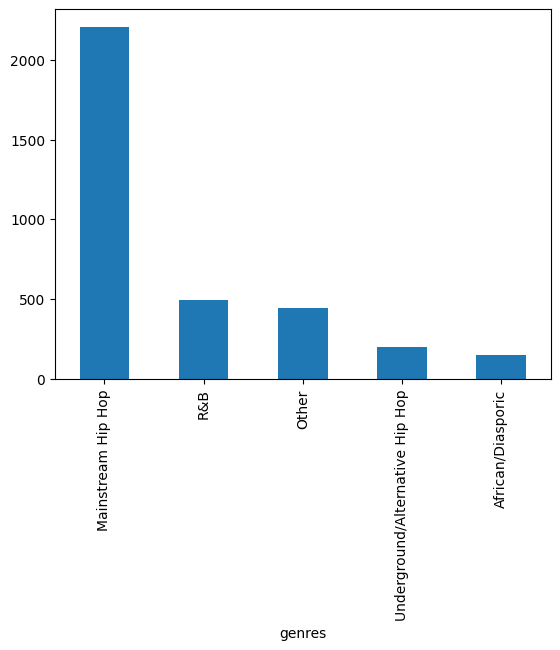

In [33]:
avg_play2['genres'].value_counts().plot(kind='bar');

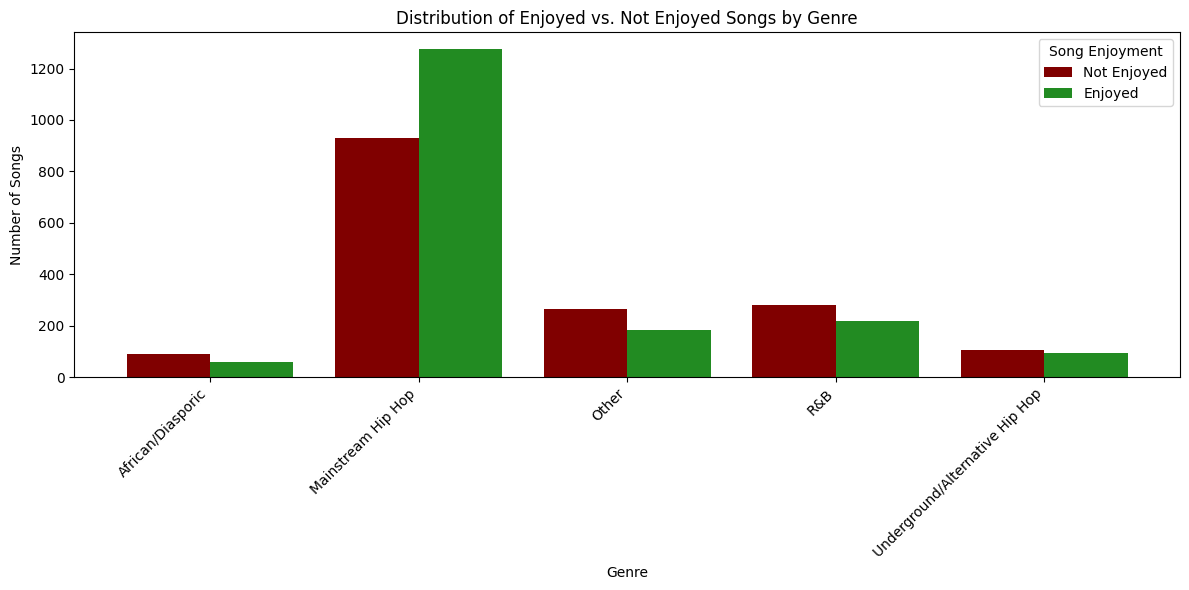

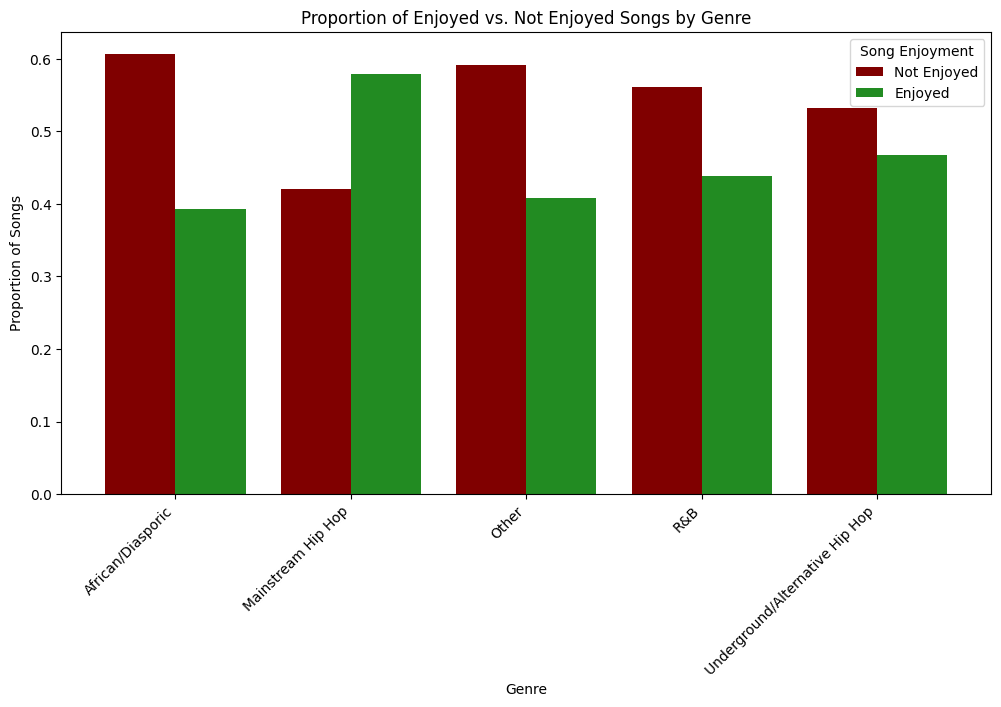

In [34]:
# Plot the distribution of enjoyed songs by genre side-by-side
# Group by 'genres' and 'enjoyed', and count the number of songs
genre_counts = avg_play2.groupby(['genres', 'enjoyed']).size().unstack(fill_value=0)

# Plot side-by-side bars
genre_counts.plot(kind='bar', figsize=(12, 6), width=0.8, color=['maroon', 'forestgreen'])

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Enjoyed vs. Not Enjoyed Songs by Genre')
plt.legend(['Not Enjoyed', 'Enjoyed'], title='Song Enjoyment')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

# Also plot the proportion of enjoyed songs by genre
genre_counts2 = genre_counts.div(genre_counts.sum(axis=1), axis=0)
genre_counts2.plot(kind='bar', figsize=(12, 6), width=0.8, color=['maroon', 'forestgreen'])

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Proportion of Songs')
plt.title('Proportion of Enjoyed vs. Not Enjoyed Songs by Genre')
plt.legend(['Not Enjoyed', 'Enjoyed'], title='Song Enjoyment')
plt.xticks(rotation=45, ha='right');  # Rotate x-axis labels


In [36]:
# List of genres to iterate over
genres = genre_counts.index.tolist()

# Define features and target column
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'liveness', 'valence', 'tempo', 'track_popularity']
target = 'enjoyed'

# Dictionary to store evaluation metrics for each genre
genre_results = {}

# Loop through each genre and fit logistic regression models
for genre in genres:
    #print(f"Training model for genre: {genre}")
    
    # Filter data for the current genre
    genre_data = avg_play2[avg_play2['genres'] == genre]
    
    # Proceed only if the genre has sufficient data
    if genre_data.shape[0] < 20:
        print(f"Skipping {genre} due to insufficient data.")
        continue
    
    # Define X (features) and y (target)
    X = genre_data[features].dropna()
    y = genre_data.loc[X.index, target]  # Align y with X
    
    # Skip if target has only one class
    if len(y.unique()) < 2:
        print(f"Skipping {genre} because only one class is present in 'enjoyed'.")
        continue
    
    # Split into train-test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Apply SMOTE to balance the training set
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Initialize and fit logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_res, y_train_res)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    genre_results[genre] = {
        'accuracy': report['accuracy'],
        'precision': report['True']['precision'] if 'True' in report else 0,
        'recall': report['True']['recall'] if 'True' in report else 0,
        'f1-score': report['True']['f1-score'] if 'True' in report else 0,
        'auc': auc
    }

    #print(f"Accuracy: {report['accuracy']:.4f}, AUC: {auc:.4f}")

# Convert results dictionary to a DataFrame for summary
results_df = pd.DataFrame(genre_results).T
print("\nSummary of Logistic Regression Results by Genre:")
display(results_df)



Summary of Logistic Regression Results by Genre:


,accuracy,precision,recall,f1-score,auc
African/Diasporic,0.466667,0.333333,0.333333,0.333333,0.328704
Mainstream Hip Hop,0.566893,0.620301,0.647059,0.633397,0.560869
Other,0.600000,0.510638,0.648649,0.571429,0.555839
R&B,0.540000,0.480769,0.568182,0.520833,0.592532
Underground/Alternative Hip Hop,0.475000,0.461538,0.631579,0.533333,0.516291


The logistic regression models, with SMOTE applied to address class imbalance, showed varying performance across genres. Mainstream Hip Hop and Other achieved the best results, with accuracy around 57-60% and AUC values of 0.56, indicating moderate predictive ability. Recall was generally high, particularly for Underground/Alternative Hip Hop (0.63), reflecting the model's strength in identifying "enjoyed" songs, though precision remained lower. In contrast, African/Diasporic performed poorly (AUC = 0.33), likely due to limited data. Overall, performance improved for minority class predictions, but smaller genres still pose challenges due to data scarcity.

## K-Nearest-Neighbors


Best k: 46, Accuracy: 0.5528


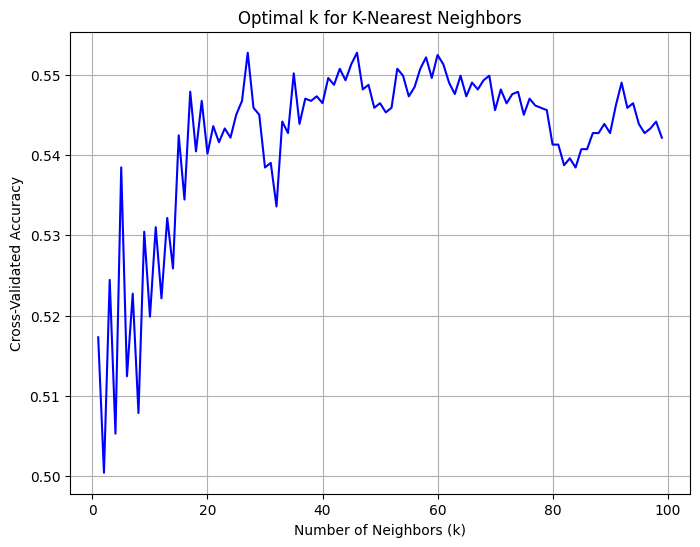

In [37]:

# One-hot encode the 'genres' column
avg_play2 = pd.get_dummies(avg_play2, columns=['genres'])

# Define features and target column
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'liveness', 'valence', 'tempo', 'track_popularity'] + \
            [col for col in avg_play2.columns if 'genres' in col] + \
            [col for col in avg_play2.columns if 'time_signature' in col or 'key' in col]

target = 'enjoyed'

# Prepare X (features) and y (target)
X = avg_play2[features].dropna()
y = avg_play2.loc[X.index, target]

# Standardize the features for KNN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Find the best k (number of neighbors)
k_values = range(1, 100)  # Test k values
mean_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=cv, scoring='accuracy')
    mean_accuracies.append(np.mean(scores))
    #print(f"k = {k}, Mean Accuracy: {np.mean(scores):.4f}")

# Find the best k
best_k = k_values[np.argmax(mean_accuracies)]
print(f"\nBest k: {best_k}, Accuracy: {max(mean_accuracies):.4f}")

# Plot k vs. cross-validated accuracy
plt.figure(figsize=(8, 6))
plt.plot(k_values, mean_accuracies, linestyle='-', color='blue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal k for K-Nearest Neighbors')
plt.grid()
plt.show()

The plot shows the cross-validated accuracy of a K-Nearest Neighbors (KNN) model as the number of neighbors k increases. The accuracy improves consistently as k rises from small values, stabilizing around k=27, where it reaches one of its peaks. This suggests that k=27 offers an optimal trade-off: it balances the model's ability to generalize without overfitting to noise, while still maintaining strong interpretability compared to higher k-values. After k=27, the accuracy fluctuates slightly but remains relatively stable around 54-55%. This stabilization indicates diminishing returns as k increases further. Larger k-values smooth out predictions but may reduce the model's sensitivity to more nuanced patterns.

Despite incorporating audio features and genre data, the model's best accuracy remains modest (around 55%). This suggests that listening behavior may not be fully captured by the available data. Important factors such as mood, context (e.g., time of day), personal associations with songs, or unexplored song metadata (like lyrics or artist familiarity) likely influence my enjoyment and are absent from the current dataset. Further enhancements, such as including temporal trends, song sequencing, or contextual features, could better model these behaviors.

# Experimenting With More Granular Notions of Enjoyment

### Granular Enjoyment Score

The enjoyment score is designed to capture the degree of enjoyment for each song based on three key components:

- **Completion Rate**: The proportion of the song that was listened to, indicating engagement.
- **Play Count**: The number of times a song was replayed, reflecting repeat enjoyment.
- **Track Popularity**: Adjusts for song popularity to account for bias towards mainstream music.

These components are combined into a **weighted score** to reflect enjoyment more precisely.

#### Mathematical Formula:
$$
\text{Enjoyment Score} = w_1 \times \text{Completion Rate} + w_2 \times \log(\text{Play Count} + 1) + w_3 \times \text{Track Popularity (normalized)}
$$
- $w_1, w_2, w_3$ are weights to control the contribution of each component.
- **Logarithmic scaling** for play count ensures diminishing returns for songs played many times.
- **Normalization** of track popularity keeps it in line with other features for balanced influence.

This granular score provides a richer, continuous measure of song enjoyment compared to a binary "Enjoyed" or "Not Enjoyed" outcome.


In [43]:
# Copy of data
data = avg_play2.copy()

# Normalize track popularity
scaler = MinMaxScaler()
data['track_popularity_normalized'] = scaler.fit_transform(data[['track_popularity']])

# Features and target
X = data[['avg_completion_rate', 'total_plays', 'track_popularity_normalized']]
y = data['enjoyed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to calculate enjoyment score
def enjoyment_score(w1, w2, w3, X):
    return (
        w1 * X['avg_completion_rate'] + 
        w2 * np.log1p(X['total_plays']) + 
        w3 * X['track_popularity_normalized']
    )

# Define a function to optimize weights
def optimize_weights(params):
    w1, w2, w3 = params
    X_train['enjoyment_score'] = enjoyment_score(w1, w2, w3, X_train)
    X_test['enjoyment_score'] = enjoyment_score(w1, w2, w3, X_test)
    
    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train[['enjoyment_score']], y_train)
    y_pred = model.predict_proba(X_test[['enjoyment_score']])[:, 1]
    
    # Evaluate using ROC-AUC
    return -roc_auc_score(y_test, y_pred)  # Negative because we minimize in optimization

# Grid Search over weights

# Initial weights and bounds
initial_weights = [0.3, 0.3, 0.4]  # Start with equal weights
bounds = [(0, 1), (0, 1), (0, 1)]  # Each weight is between 0 and 1

# Optimization
result = minimize(optimize_weights, initial_weights, bounds=bounds, method='L-BFGS-B')

# Best weights
best_weights = result.x
print(f"Optimal Weights: w1 = {best_weights[0]:.4f}, w2 = {best_weights[1]:.4f}, w3 = {best_weights[2]:.4f}")

Optimal Weights: w1 = 0.3000, w2 = 0.3000, w3 = 0.4000


To optimize the weights for the enjoyment score components, a logistic regression model was used to predict whether a song was "enjoyed." The weights for completion rate, play count, and track popularity were optimized using `scipy`'s minimize function, which aimed to maximize the predictive performance measured by ROC-AUC. The objective function calculated the negative ROC-AUC for each combination of weights, allowing the optimizer to adjust the contributions of each component iteratively. The resulting optimal weights of $w_1 = 0.3$, $w_2 = 0.3$, and $w_3 = 0.4$ provide the best balance to predict enjoyment based on the data.

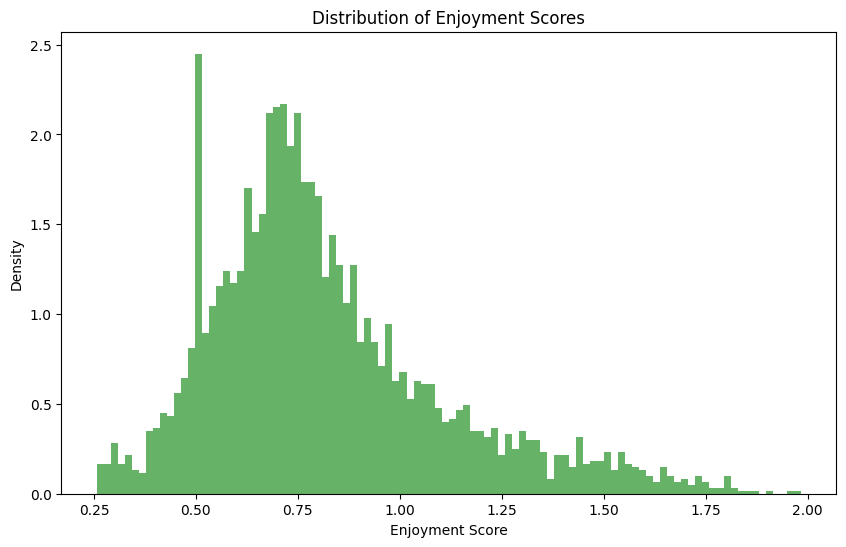

In [44]:
data['enjoyment_score'] = enjoyment_score(*best_weights, data)

# Plot the distribution of enjoyment scores
plt.figure(figsize=(10, 6))
plt.hist(data['enjoyment_score'], bins=100, alpha=0.6, color='green', density=True)
plt.xlabel('Enjoyment Score')
plt.ylabel('Density')
plt.title('Distribution of Enjoyment Scores')
plt.show();

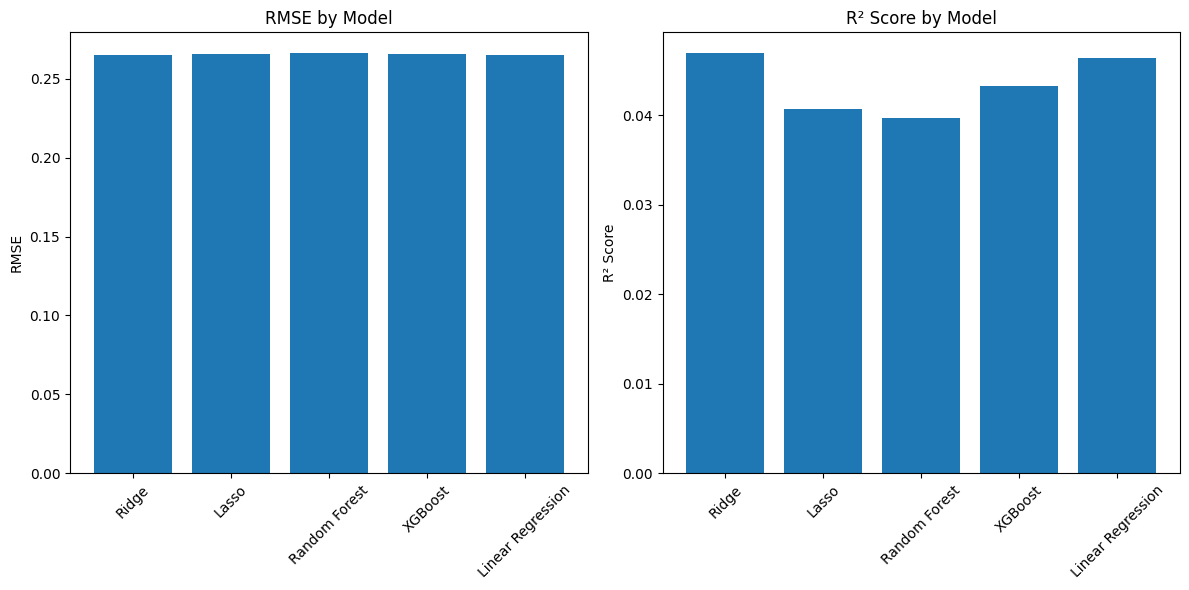

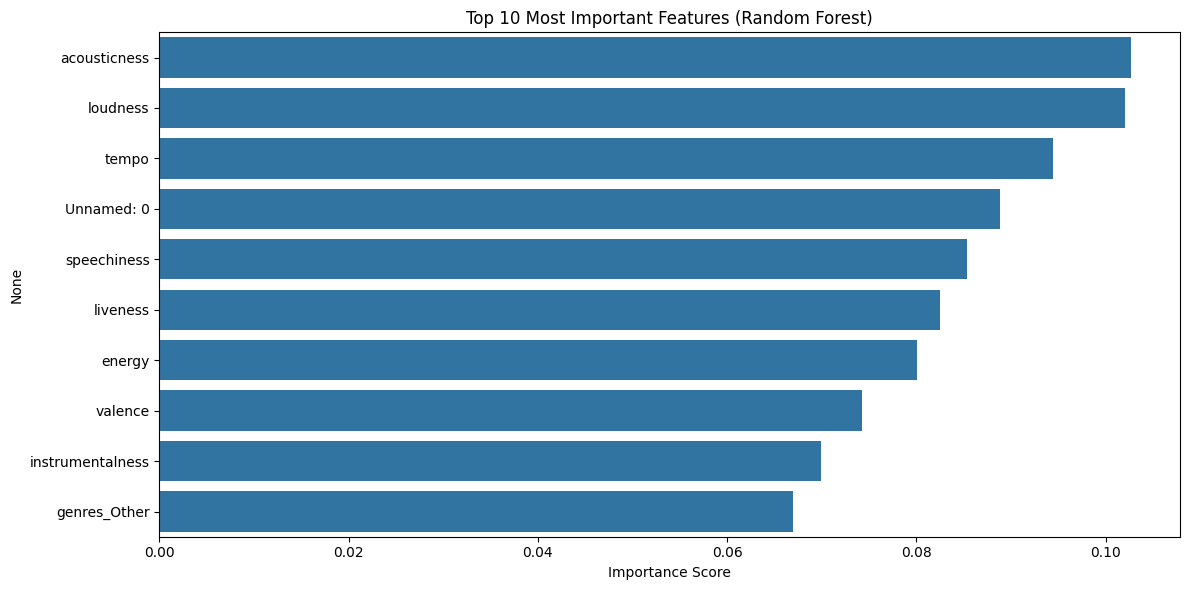

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_features(df):
    """Prepare features for model training."""
    drop_columns = ['track_id', 'artist_id', 'track_name', 'artist_name', 
                   'enjoyed', 'enjoyment_score', 'play_category', "total_plays",
                   'track_popularity', 'track_popularity_normalized', 'avg_completion_rate', 'average_seconds_played']
    
    features = df.drop(columns=drop_columns)
    
    return features

def perform_hyperparameter_tuning(X_train_scaled, y_train):
    """Perform grid search for hyperparameter tuning."""
    param_grids = {
        'Ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                'solver': ['auto', 'svd', 'cholesky']
            }
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
                'selection': ['cyclic', 'random']
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
            'params': {
                'max_depth': [3, 5, 7],
                'learning_rate': [0.01, 0.1, 0.3],
                'n_estimators': [100, 200]
            }
        }
    }
    
    best_models = {}
    
    for name, config in param_grids.items():
        #print(f"\nTuning {name}...")
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train)
        
        #print(f"Best parameters: {grid_search.best_params_}")
        #print(f"Best RMSE: {-grid_search.best_score_:.4f}")
        
        best_models[name] = grid_search.best_estimator_
    
    return best_models

def visualize_results(results, feature_importance):
    """Create visualizations for model performance and feature importance."""
    # Model Performance Comparison
    plt.figure(figsize=(12, 6))
    
    # RMSE Comparison
    plt.subplot(1, 2, 1)
    rmse_scores = [metrics['RMSE'] for metrics in results.values()]
    plt.bar(results.keys(), rmse_scores)
    plt.title('RMSE by Model')
    plt.xticks(rotation=45)
    plt.ylabel('RMSE')
    
    # R² Comparison
    plt.subplot(1, 2, 2)
    r2_scores = [metrics['R2'] for metrics in results.values()]
    plt.bar(results.keys(), r2_scores)
    plt.title('R² Score by Model')
    plt.xticks(rotation=45)
    plt.ylabel('R² Score')
    
    plt.tight_layout()
    
    # Feature Importance Plot
    if 'Random Forest' in feature_importance:
        plt.figure(figsize=(12, 6))
        top_features = feature_importance['Random Forest'].head(10)
        sns.barplot(x=top_features.values, y=top_features.index)
        plt.title('Top 10 Most Important Features (Random Forest)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
    
    plt.show()

def predict_enjoyment(df):
    """Main function to run the enjoyment prediction pipeline."""
    # Prepare features
    X = prepare_features(df)
    y = df['enjoyment_score']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform hyperparameter tuning
    #print("Performing hyperparameter tuning...")
    best_models = perform_hyperparameter_tuning(X_train_scaled, y_train)
    
    # Add Linear Regression (no hyperparameters to tune)
    best_models['Linear Regression'] = LinearRegression()
    best_models['Linear Regression'].fit(X_train_scaled, y_train)
    
    results = {}
    feature_importance = {}
    
    # Evaluate each tuned model
    for name, model in best_models.items():
        if name != 'Linear Regression':  # Skip Linear Regression as it's already fitted
            model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'RMSE': rmse,
            'R2': r2
        }
        
        # Get feature importance if available
        if hasattr(model, 'feature_importances_'):
            feature_importance[name] = pd.Series(
                model.feature_importances_,
                index=X_train.columns
            ).sort_values(ascending=False)
        elif name == 'Linear Regression':
            feature_importance[name] = pd.Series(
                model.coef_,
                index=X_train.columns
            ).abs().sort_values(ascending=False)
    
    # Print results
    # print("\nModel Performance Comparison:")
    # print("-" * 50)
    # for model_name, metrics in results.items():
    #     print(f"\n{model_name}:")
    #     print(f"RMSE: {metrics['RMSE']:.4f}")
    #     print(f"R2 Score: {metrics['R2']:.4f}")
    
    # Create visualizations
    visualize_results(results, feature_importance)
    
    return results, feature_importance, scaler, best_models

# Example usage:
results, feature_importance, scaler, best_models = predict_enjoyment(data)

The machine learning models' performance in predicting music enjoyment scores reveals several interesting patterns. Looking at the evaluation metrics, all models showed relatively consistent RMSE values around 0.26, indicating similar prediction accuracy across different approaches. However, the R² scores, which measure the proportion of variance explained by the models, show more notable differences.

Linear Regression and Ridge Regression performed best with R² scores around 0.045 (4.5%), followed by XGBoost at approximately 0.042 (4.2%). The Random Forest and Lasso models showed slightly lower performance with R² scores around 0.03-0.04 (3-4%). While these R² values are relatively low, suggesting that predicting music enjoyment is a complex task that may involve factors beyond the available features, they still provide valuable insights into feature importance.

The feature importance analysis from the Random Forest model reveals the most influential factors in predicting enjoyment:

1. Audio Characteristics: The top three predictors are loudness, acousticness, and tempo, suggesting that the technical aspects of a song's production and composition significantly influence listener enjoyment.

2. Vocal Elements: Speechiness and liveness rank highly (4th and 5th), indicating that the presence and quality of vocal components play a substantial role in listener engagement.

3. Emotional and Energy Factors: Valence (emotional positivity) and energy appear as the 6th and 7th most important features, showing that a song's emotional content and energy level are meaningful predictors of enjoyment.

4. Musical Structure: Danceability and instrumentalness round out the top features, demonstrating that the overall musical structure and composition style contribute to listener enjoyment.

5. Genre Impact: The presence of `genres_Other` in the top 10 suggests that genre classification has some predictive power, though relatively lower than the audio features.

These findings suggest that while predicting music enjoyment is challenging due to its subjective nature, certain technical and compositional elements consistently influence listener preferences. The similar performance across different modeling approaches indicates that the relationship between these features and enjoyment is relatively stable, though complex and potentially non-linear.

# Conclusion

In [1]:
%%capture
from nbconvert import PDFExporter
import nbformat

# Read the notebook
with open('Analysis.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

# Configure the exporter
pdf_exporter = PDFExporter()
pdf_exporter.exclude_input = True

# Convert the notebook
pdf_output, resources = pdf_exporter.from_notebook_node(nb)

# Write the output to a file
with open('AnalysisV1.pdf', 'wb') as f:  # Note: 'wb' for binary write mode
    f.write(pdf_output)